In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sb
import psycopg2
import itertools

In [227]:
connection = psycopg2.connect(
    host="localhost",
    database="50_in_07",
    user="tanyatang")

In [215]:
cursor = connection.cursor()
cursor.execute(
    """
    SELECT row_to_json(games.*)
         , row_to_json(game_goalies.*)
         , row_to_json(players.*)
         , row_to_json(teams.*)
      FROM games 
      JOIN game_goalies
        ON games.id = game_goalies.game_id
      JOIN players
        ON game_goalies.player_id = players.id
      JOIN teams
        ON (games.away_team_id + games.home_team_id - 10) = teams.id
     WHERE players.id = 8475883
    """)
results = cursor.fetchall()
cursor.close()

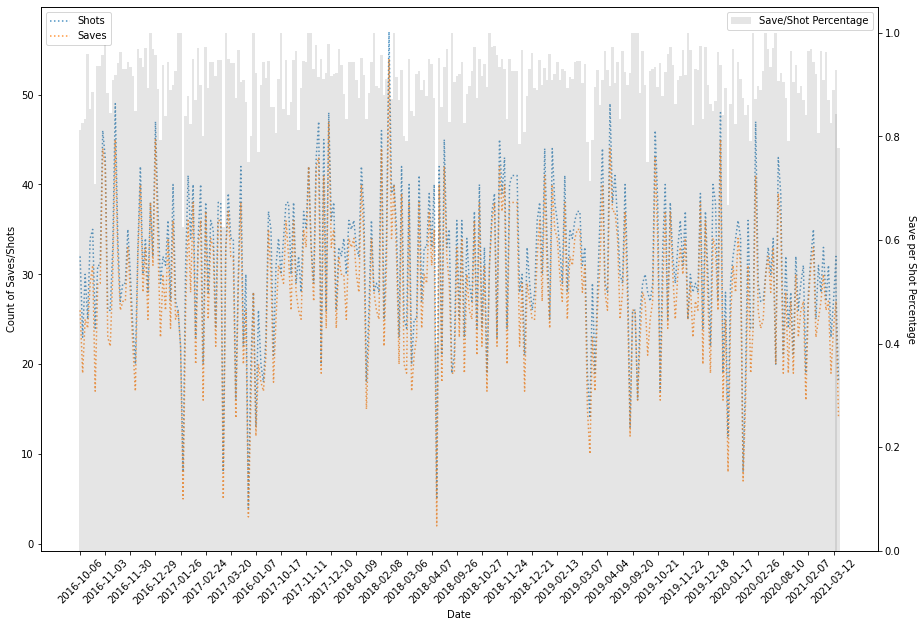

In [216]:
fig, ax = plt.subplots(figsize=(15, 10))
second_ax = ax.twinx()
second_ax.bar(list(map(lambda x: str(x[0]["date"]), results)),
              list(map(lambda x: x[1]["saves"] / x[1]["shots"], results)),
              width=1,
              color='grey',
              alpha=0.2,
              label='Save/Shot Percentage')
ax.plot(list(map(lambda x: str(x[0]["date"]), results)), 
        list(map(lambda x: x[1]["shots"], results)),
        ':',
        alpha=0.8,
        label='Shots')
ax.plot(list(map(lambda x: str(x[0]["date"]), results)),
        list(map(lambda x: x[1]["saves"], results)),
        ':',
        alpha=0.8,
        label='Saves')
ax.set_xticks(list(map(lambda x: str(x[0]["date"]), results))[::10])
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
ax.set_xlabel('Date')
ax.set_ylabel('Count of Saves/Shots')
second_ax.set_ylabel('Save per Shot Percentage',
                     rotation=270,
                     labelpad=15)
ax.legend(loc='upper left')
second_ax.legend(loc='upper right')
plt.show()

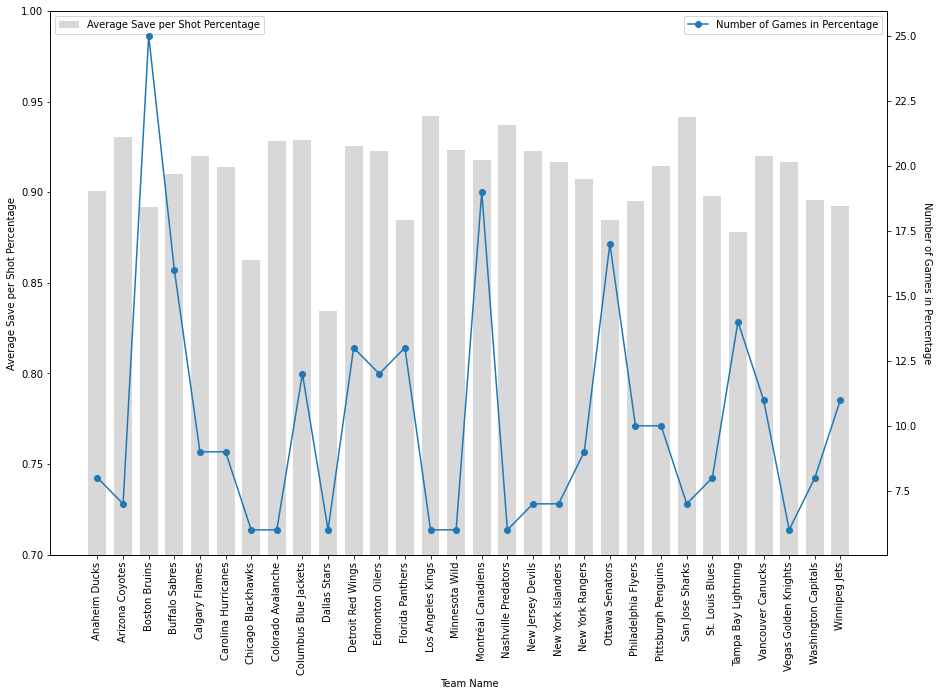

In [217]:
grouped_by_other_team = sorted(list(map(lambda x: [x[3]["name"], x[1]["saves"] / x[1]["shots"]], results)))
average_by_other_team = [[item[0], np.average(list(map(lambda x: x[1], item[1])))]
                         for item in itertools.groupby(grouped_by_other_team, key=lambda x: x[0])]
count_by_other_team = [[item[0], len(list(map(lambda x: x[1], item[1])))]
                        for item in itertools.groupby(grouped_by_other_team, key=lambda x: x[0])]
fig, ax = plt.subplots(figsize=(15, 10))
second_ax = ax.twinx()
second_ax.plot(list(map(lambda x: x[0], count_by_other_team)),
               list(map(lambda x: x[1], count_by_other_team)),
               '-o',
               label='Number of Games in Percentage')
ax.bar(list(map(lambda x: x[0], average_by_other_team)),
       list(map(lambda x: x[1], average_by_other_team)),
       width=0.7,
       color='grey',
       alpha=0.3,
       label='Average Save per Shot Percentage')
ax.set_ylim(0.7, 1.0)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
ax.set_ylabel('Average Save per Shot Percentage')
second_ax.set_ylabel('Number of Games in Percentage',
                     rotation=270,
                     labelpad=15)
ax.set_xlabel('Team Name')
ax.legend(loc='upper left')
second_ax.legend(loc='upper right')
plt.show()

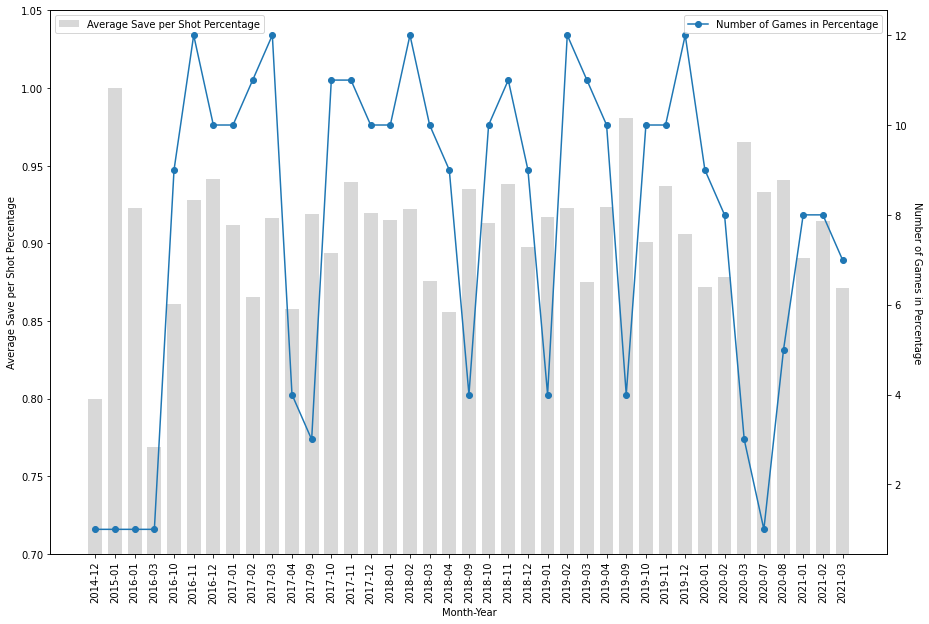

In [221]:
grouped_by_month_year = sorted(list(map(lambda x: [str(x[0]["date"])[:7], x[1]["saves"] / x[1]["shots"]], results)))
average_by_month_year = [[item[0], np.average(list(map(lambda x: x[1], item[1])))]
                         for item in itertools.groupby(grouped_by_month_year, key=lambda x: x[0])]
count_by_month_year = [[item[0], len(list(map(lambda x: x[1], item[1])))]
                        for item in itertools.groupby(grouped_by_month_year, key=lambda x: x[0])]
fig, ax = plt.subplots(figsize=(15, 10))
second_ax = ax.twinx()
second_ax.plot(list(map(lambda x: x[0], count_by_month_year)),
               list(map(lambda x: x[1], count_by_month_year)),
               '-o',
               label='Number of Games in Percentage')
ax.bar(list(map(lambda x: x[0], average_by_month_year)),
       list(map(lambda x: x[1], average_by_month_year)),
       width=0.7,
       color='grey',
       alpha=0.3,
       label='Average Save per Shot Percentage')
ax.set_ylim(0.7, 1.05)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
ax.set_ylabel('Average Save per Shot Percentage')
second_ax.set_ylabel('Number of Games in Percentage',
                     rotation=270,
                     labelpad=15)
ax.set_xlabel('Month-Year')
ax.legend(loc='upper left')
second_ax.legend(loc='upper right')
plt.show()

In [231]:
cursor = connection.cursor()
cursor.execute(
    """
    SELECT row_to_json(players.*)
         , row_to_json(game_play_players.*)
         , row_to_json(game_plays.*)
      FROM players
      JOIN game_play_players
        ON players.id = game_play_players.player_id
      JOIN game_plays
        ON (game_play_players.game_id = game_plays.game_id
            AND game_play_players.play_num = game_plays.play_num)
    """)
results = cursor.fetchall()
cursor.close()

In [280]:
grouped_by_play_and_player = [{'name': results[i][0]['first_name'] + ' ' + results[i][0]['last_name'],
                               'height': results[i][0]['height'],
                               'weight': results[i][0]['weight'],
                               'play_player_type': results[i][1]['play_player_type'],
                               'play_type': results[i][2]['play_type'],
                               'time': results[i][2]['time'],
                               'period_time_elapsed': results[i][2]['period_time_elapsed'],
                               'period': results[i][2]['period'],
                               'period_type': results[i][2]['period_type']} for i in range(0, len(results))]

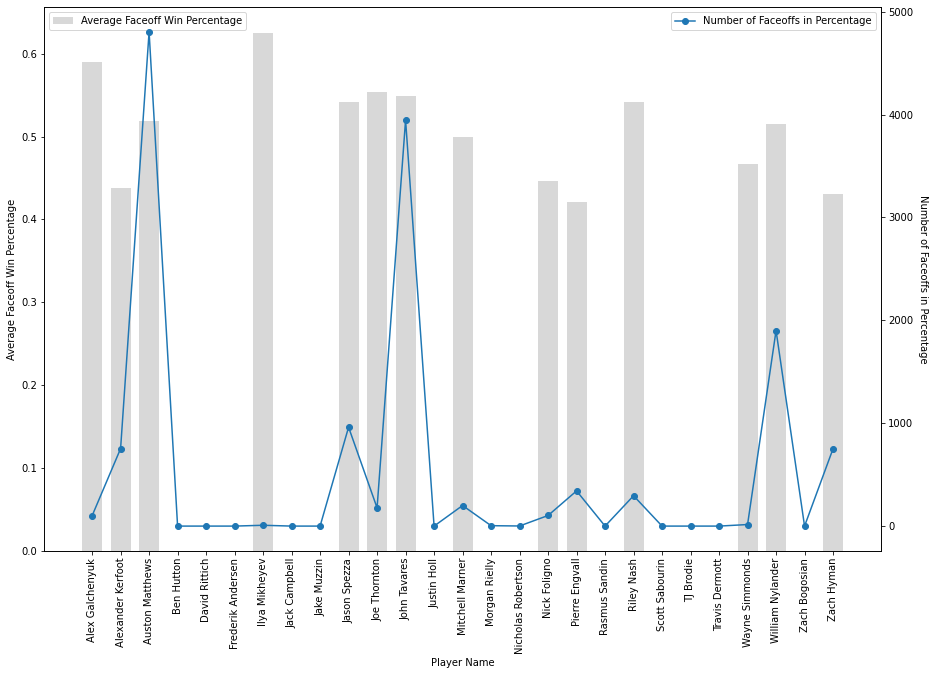

In [270]:
faceoff_winners_per_player = [[item[0],
                               len(list(filter(lambda x: x['play_player_type'] == 'Winner' and
                                               x['play_type'] == 'Faceoff', item[1])))]
                              for item in itertools.groupby(sorted(grouped_by_play_and_player,
                                                                   key=lambda x: x['name']),
                                                            key=lambda x: x['name'])]
faceoff_total_per_player = [[item[0],
                             len(list(filter(lambda x: x['play_type'] == 'Faceoff', item[1])))]
                            for item in itertools.groupby(sorted(grouped_by_play_and_player,
                                                                 key=lambda x: x['name']),
                                                          key=lambda x: x['name'])]
faceoff_win_percentage_per_play = [[faceoff_winners_per_player[i][0],
                                    faceoff_winners_per_player[i][1] / faceoff_total_per_player[i][1]
                                    if faceoff_total_per_player[i][1] > 0
                                    else 0]
                                   for i in range(len(faceoff_winners_per_player))]
fig, ax = plt.subplots(figsize=(15, 10))
second_ax = ax.twinx()
second_ax.plot(list(map(lambda x: x[0], faceoff_total_per_player)),
               list(map(lambda x: x[1], faceoff_total_per_player)),
               '-o',
               label='Number of Faceoffs in Percentage')
ax.bar(list(map(lambda x: x[0], faceoff_win_percentage_per_play)),
       list(map(lambda x: x[1], faceoff_win_percentage_per_play)),
       width=0.7,
       color='grey',
       alpha=0.3,
       label='Average Faceoff Win Percentage')
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
ax.set_ylabel('Average Faceoff Win Percentage')
second_ax.set_ylabel('Number of Faceoffs in Percentage',
                     rotation=270,
                     labelpad=15)
ax.set_xlabel('Player Name')
ax.legend(loc='upper left')
second_ax.legend(loc='upper right')
plt.show()

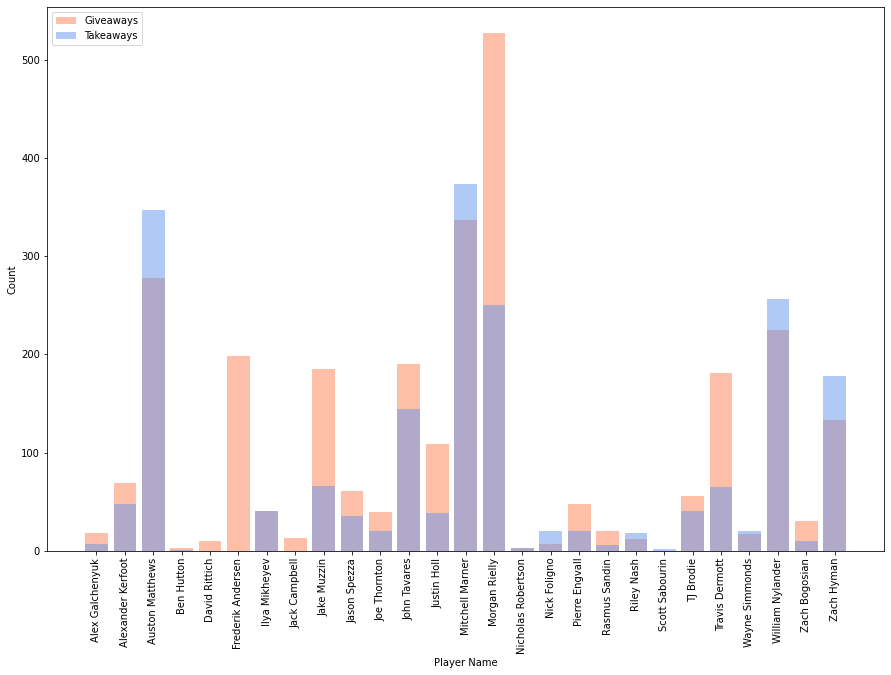

In [279]:
takeaways_per_player = [[item[0],
                         len(list(filter(lambda x: x['play_type'] == 'Takeaway', item[1])))]
                        for item in itertools.groupby(sorted(grouped_by_play_and_player,
                                                             key=lambda x: x['name']),
                                                      key=lambda x: x['name'])]
giveaways_per_player = [[item[0],
                         len(list(filter(lambda x: x['play_type'] == 'Giveaway', item[1])))]
                        for item in itertools.groupby(sorted(grouped_by_play_and_player,
                                                             key=lambda x: x['name']),
                                                      key=lambda x: x['name'])]
fig, ax = plt.subplots(figsize=(15, 10))
ax.bar(list(map(lambda x: x[0], giveaways_per_player)),
       list(map(lambda x: x[1], giveaways_per_player)),
       color='coral',
       alpha=0.5,
       label='Giveaways')
ax.bar(list(map(lambda x: x[0], takeaways_per_player)),
       list(map(lambda x: x[1], takeaways_per_player)),
       color='cornflowerblue',
       alpha=0.5,
       label='Takeaways')
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
ax.set_ylabel('Count')
ax.set_xlabel('Player Name')
ax.legend(loc='upper left')
plt.show()

In [ ]:
takeaways_per_player = [[item[0],
                         len(list(filter(lambda x: x['play_type'] == 'Takeaway', item[1])))]
                        for item in itertools.groupby(sorted(grouped_by_play_and_player,
                                                             key=lambda x: x['name']),
                                                      key=lambda x: x['name'])]
giveaways_per_player = [[item[0],
                         len(list(filter(lambda x: x['play_type'] == 'Giveaway', item[1])))]
                        for item in itertools.groupby(sorted(grouped_by_play_and_player,
                                                             key=lambda x: x['name']),
                                                      key=lambda x: x['name'])]

In [211]:
connection.close()